# 10. Denoising Autoencoder for Image Classifier pretraining

_Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

## Prepare environment

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers

from matplotlib import pyplot as plt

import numpy as np

import math

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

2025-04-01 11:40:50.886752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743500450.982898    6268 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743500451.013325    6268 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 11:40:51.320812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## MNIST

### Split the dataset into a training set and a test set.

In [4]:
train, test = tfds.as_numpy(
    tfds.load(
        "mnist",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        batch_size=-1,
    )
)

I0000 00:00:1743500461.767855    6268 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1
2025-04-01 11:41:03.148878: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [5]:
X_train_full, y_train_full, X_test, y_test = train[0], train[1], test[0], test[1]

In [6]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [7]:
for image in X_train[:5]:
  print(image.shape)

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


In [8]:
for image in X_test[:5]:
  print(image.shape)

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


In [9]:
y_train[:5]

array([4, 1, 0, 7, 8])

In [10]:
y_test[:5]

array([2, 0, 4, 8, 7])

### Train a deep denoising autoencoder on the full training set.

In [ ]:
encoder = keras.Sequential([
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(100, activation="relu"),
    layers.Dense(30, activation="relu")
])
decoder = keras.Sequential([
    layers.Dense(100, activation="relu"),
    layers.Dense(28 * 28),
    layers.Reshape([28, 28])
])
autoencoder = keras.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer="nadam")
history = autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10


I0000 00:00:1743500469.979380    6508 service.cc:148] XLA service 0x7f866c0065b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743500469.979906    6508 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-04-01 11:41:10.094083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743500470.270265    6508 cuda_dnn.cc:529] Loaded cuDNN version 90700


  46/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0922  

I0000 00:00:1743500473.058943    6508 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0442 - val_loss: 0.0274
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0292 - val_loss: 0.0253
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0273 - val_loss: 0.0241
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0261 - val_loss: 0.0233
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0253 - val_loss: 0.0228
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0248 - val_loss: 0.0224
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0244 - val_loss: 0.0222
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0241 - val_loss: 0.0220
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0239 - val_loss: 0.0217
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0237 - val_loss: 0.0216


### Check that the images are fairly well reconstructed

In [12]:
def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


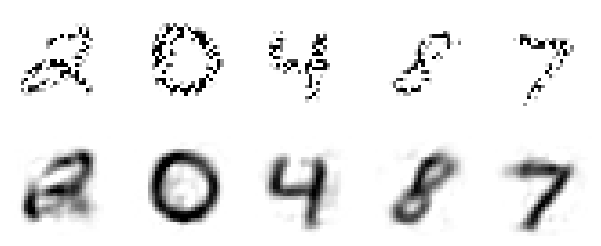

In [ ]:
dropout = layers.Dropout(0.5)
plot_reconstructions(autoencoder, dropout(X_test, training=True))
plt.show()

### Visualize the images that most activate each neuron in the coding layer

In [14]:
def select_representative_images(x_test, y_test):
    """
    Select one representative image for each digit class
    
    Args:
        x_test (np.array): Test images
        y_test (np.array): Test labels
    
    Returns:
        tuple: Selected images and their corresponding labels
    """
    # Unique classes (0-9)
    classes = np.unique(y_test)
    
    # Storage for selected images
    selected_images = []
    selected_labels = []
    
    for digit in classes:
        # Find indices of images with this digit
        digit_indices = np.where(y_test == digit)[0]
        
        # Select first image of this digit (you could use random selection too)
        first_image_index = digit_indices[0]
        
        selected_images.append(x_test[first_image_index])
        selected_labels.append(y_test[first_image_index])
    
    return (np.array(selected_images), np.array(selected_labels))

def visualize_neuron_activations_per_class(encoder, x_test, y_test):
    """
    Visualize neuron activations for representative images of each class
    
    Args:
        encoder (keras.Model): Trained encoder model
        x_test (np.array): Test images
        y_test (np.array): Test labels
    """
    # Select one image per class
    class_images, class_labels = select_representative_images(x_test, y_test)
    
    # Get neuron activations for these images
    activations = encoder.predict(class_images)
    
    # Visualization
    plt.figure(figsize=(15, 6))
    
    # Images
    for i in range(len(class_images)):
        plt.subplot(2, 10, i + 1)
        plt.imshow(class_images[i].squeeze(), cmap='gray')
        plt.title(f'Digit: {class_labels[i]}')
        plt.axis('off')
    
    # Neuron Activations
    plt.subplot(2, 1, 2)
    plt.imshow(activations, aspect='auto', cmap='viridis')
    plt.title('Neuron Activations per Digit Class')
    plt.xlabel('Neuron Index')
    plt.ylabel('Digit Class')
    plt.colorbar(label='Activation Strength')
    
    # Add class labels to y-axis
    plt.yticks(range(len(class_labels)), [str(label) for label in class_labels])
    plt.xticks(range(len(activations[0])))
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


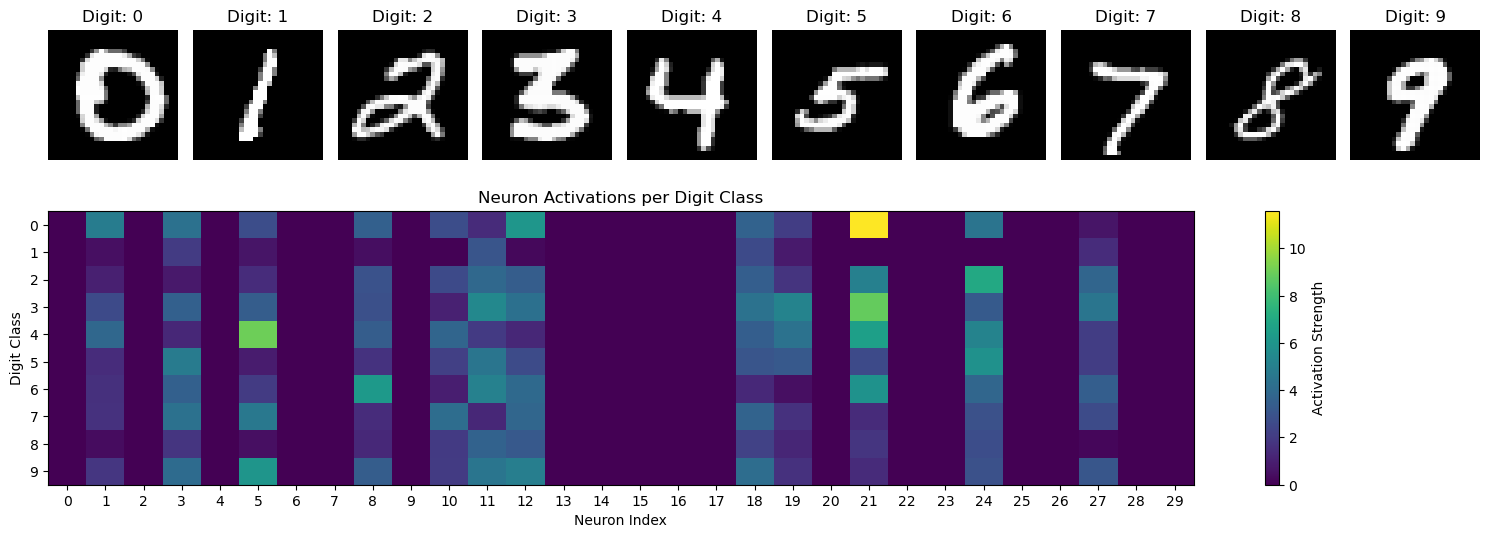

In [ ]:
visualize_neuron_activations_per_class(encoder, X_test, y_test)

### Build a classification DNN, reusing the lower layers of the autoencoder.

In [16]:
num_classes = len(np.unique(y_test))
num_classes

10

In [ ]:
def create_and_compile_model(pretraining: bool):
    model = keras.Sequential()

    if (pretraining):
        encoder.trainable = False
        model.add(encoder)

    for _ in range(20):
        model.add(layers.Dense(100, kernel_initializer="he_normal"))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation("swish"))

    model.add(layers.Dense(num_classes, activation="softmax"))

    optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    
    return model

model = create_and_compile_model(pretraining=True)

### Train it using only 500 images from the training set.

In [ ]:
def train_model(model):
    early_stopping_cb = keras.callbacks.EarlyStopping(
        patience=20, restore_best_weights=True
    )

    model.fit(
        X_train[:500],
        y_train[:500],
        epochs=100,
        validation_data=(X_valid[:500], y_valid[:500]),
        callbacks=[early_stopping_cb],
    )

train_model(model)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 477ms/step - accuracy: 0.1598 - loss: 2.4649 - val_accuracy: 0.1000 - val_loss: 2.8309
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1658 - loss: 2.2615 - val_accuracy: 0.1220 - val_loss: 2.6601
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2294 - loss: 2.1797 - val_accuracy: 0.1220 - val_loss: 2.7366
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2614 - loss: 2.0181 - val_accuracy: 0.1460 - val_loss: 2.5841
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3338 - loss: 1.9769 - val_accuracy: 0.1500 - val_loss: 2.4660
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4368 - loss: 1.7640 - val_accuracy: 0.1740 - val_loss: 2.3955
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5377 - loss: 1.5873 - val_accuracy: 0.2080 - val_loss: 2.3795
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5239 - loss: 1.4699 - val_accuracy: 

### Does it perform better with or without pretraining?

In [ ]:
model_without_pretraining = create_and_compile_model(pretraining=False)
train_model(model_without_pretraining)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 416ms/step - accuracy: 0.0826 - loss: 2.5982 - val_accuracy: 0.0960 - val_loss: 2.3026
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1849 - loss: 2.2480 - val_accuracy: 0.0960 - val_loss: 2.3033
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2973 - loss: 2.0351 - val_accuracy: 0.0960 - val_loss: 2.3050
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3878 - loss: 1.8687 - val_accuracy: 0.2000 - val_loss: 2.3068
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4953 - loss: 1.6843 - val_accuracy: 0.1800 - val_loss: 2.3078
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5656 - loss: 1.4756 - val_accuracy: 0.2080 - val_loss: 2.3043
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6385 - loss: 1.3201 - val_accuracy: 0.2060 - val_loss: 2.2961
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6984 - loss: 1.1117 - val_accuracy: 

In [ ]:
print("Model's accuracy with pretraining:")
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8125 - loss: 0.7168


[0.7401506900787354, 0.8075000047683716]

In [ ]:
print("Model's accuracy without pre-training:")
model_without_pretraining.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3390 - loss: 1.9705


[1.9573436975479126, 0.3458000123500824]

## CIFAR10

Not doing denoising on CIFAR10 because of the abysmall results - still it is interesting to see how much encoder can help with classification as a base model.

### Split the dataset into a training set and a test set.

In [23]:
train, test = tfds.as_numpy(
    tfds.load(
        "cifar10",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        batch_size=-1,
    )
)

In [24]:
X_train_full, y_train_full, X_test, y_test = train[0], train[1], test[0], test[1]

In [25]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### Train a deep autoencoder on the full training set.

Convolutional Autoencoder architecture from:
https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

In [48]:
encoder = keras.Sequential(
    [
        layers.Reshape([32, 32, 3]),
        layers.Conv2D(12, 4, strides=2, padding="same", activation="relu"),
        layers.Conv2D(24, 4, strides=2, padding="same", activation="relu"),
        layers.Conv2D(48, 4, strides=2, padding="same", activation="relu"),
    ]
)
decoder = keras.Sequential(
    [
        layers.Conv2DTranspose(24, 4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(12, 4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="sigmoid"),
    ]
)
autoencoder = keras.Sequential([encoder, decoder])

autoencoder.compile(loss="binary_crossentropy", optimizer="adam", metrics=["mse"])

In [49]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=10,
    validation_data=(X_valid, X_valid),
    callbacks=[early_stopping_cb],
)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.6038 - mse: 0.0228 - val_loss: 0.5663 - val_mse: 0.0073
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5659 - mse: 0.0067 - val_loss: 0.5666 - val_mse: 0.0070
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5627 - mse: 0.0055 - val_loss: 0.5680 - val_mse: 0.0074
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5610 - mse: 0.0048 - val_loss: 0.5632 - val_mse: 0.0057
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5598 - mse: 0.0044 - val_loss: 0.5576 - val_mse: 0.0039
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.5581 - mse: 0.0037 - val_loss: 0.5577 - val_mse: 0.0038
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5574 - mse: 0.0034 - val_loss: 0.5606 - val_mse: 0.0046
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.5569 - mse: 0.0032 - val_loss: 0.5582 - val_mse: 0.0040
Epoch 9/10
1407/1407 ━━━━━━━━━━━━

Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5557 - mse: 0.0027 - val_loss: 0.5541 - val_mse: 0.0025

In [50]:
autoencoder.summary(expand_nested=True)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 4, 4, 48)       │        23,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ reshape_3 (Reshape)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_6 (Conv2D)          │ (None, 16, 16, 12)     │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_7 (Conv2D)          │ (None, 8, 8, 24)       │         4,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_8 (Conv2D)          │ (None, 4, 4, 48)       │        18,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 32, 32, 3)      │        23,655 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_transpose_6         │ (None, 8, 8, 24)       │        18,456 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_transpose_7         │ (None, 16, 16, 12)     │         4,620 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_transpose_8         │ (None, 32, 32, 3)      │           579 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,067 (554.95 KB)

 Trainable params: 47,355 (184.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 94,712 (369.97 KB)

### Check that the images are fairly well reconstructed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


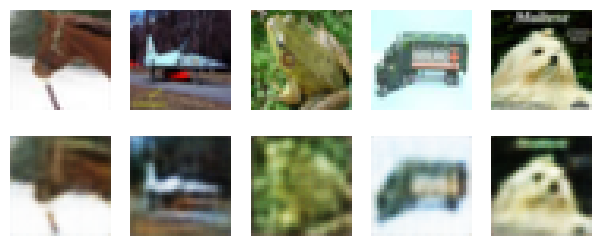

In [51]:
plot_reconstructions(autoencoder, X_test)
plt.show()

### Visualize the images that most activate each neuron in the coding layers

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


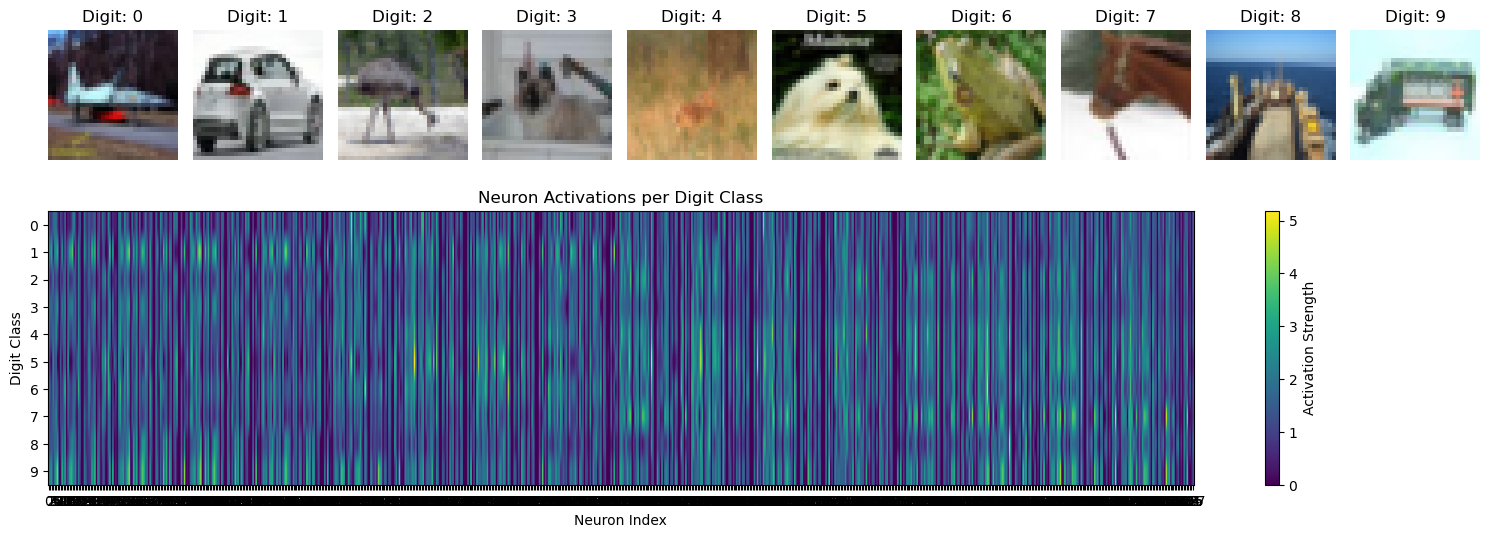

In [52]:
flat_encoder = keras.Sequential(
    [
        encoder,
        layers.Flatten()
    ]
)
visualize_neuron_activations_per_class(flat_encoder, X_test, y_test)

### Build a classification DNN, reusing the lower layers of the autoencoder.

In [53]:
num_classes = len(np.unique(y_test))
num_classes

10

In [91]:
def create_and_compile_model(pretraining:bool):
    model = keras.Sequential()

    if (pretraining):
        encoder.trainable = False
        model.add(encoder)

    model.add(layers.Flatten())

    # One Cycle Scheduling
    for _ in range(20):
        model.add(
            layers.Dense(100, kernel_initializer="lecun_normal", activation="selu")
        )
    model.add(layers.AlphaDropout(rate=0.1))

    model.add(layers.Dense(num_classes, activation="softmax"))

    optimizer = keras.optimizers.SGD(learning_rate=2e-2)
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    
    return model

model = create_and_compile_model(pretraining=True)

### Train it using only 500 images from the training set.

In [92]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

In [93]:
def train_model(model):
    n_epochs = 15
    batch_size = 128
    n_iterations = math.ceil(len(X_train) / batch_size) * n_epochs
    onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)

    early_stopping_cb = keras.callbacks.EarlyStopping(
        patience=20, restore_best_weights=True
    )

    model.fit(
        X_train[:500],
        y_train[:500],
        epochs=n_epochs,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping_cb, onecycle],
        batch_size=batch_size
    )

train_model(model)

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 884ms/step - accuracy: 0.1034 - loss: 2.8337 - val_accuracy: 0.0980 - val_loss: 2.8697
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1196 - loss: 2.7181 - val_accuracy: 0.1382 - val_loss: 2.4613
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1198 - loss: 2.4636 - val_accuracy: 0.1592 - val_loss: 2.3786
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1572 - loss: 2.4227 - val_accuracy: 0.1480 - val_loss: 2.2930
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1635 - loss: 2.4158 - val_accuracy: 0.1538 - val_loss: 2.6746
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.1341 - loss: 2.5376 - val_accuracy: 0.1470 - val_loss: 2.2944
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1782 - loss: 2.3895 - val_accuracy: 0.1156 - val_loss: 2.3762
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1467 - loss: 2.4124 - val_accuracy: 0.1628 - val_loss: 2.362

In [94]:
model.summary(show_trainable=True, expand_nested=True)

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ sequential_15 (Sequential)  │ (None, 4, 4, 48)      │     23,700 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ reshape_3 (Reshape)    │ (None, 32, 32, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv2d_6 (Conv2D)      │ (None, 16, 16, 12)    │        588 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv2d_7 (Conv2D)      │ (None, 8, 8, 24)      │      4,632 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv2d_8 (Conv2D)      │ (None, 4, 4, 48)      │     18,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_14 (Flatten)        │ (None, 768)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_199 (Dense)           │ (None, 100)           │     76,900 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_200 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_201 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_202 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_203 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_204 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_205 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_206 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_207 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_208 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_209 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_210 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_211 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_212 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_213 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_214 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_215 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_216 (Dense)           │ (None, 100)           │     10,100 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_217 (Dense)           │ (None, 100)           │     10,100 │   Y 

 Total params: 293,512 (1.12 MB)

 Trainable params: 269,810 (1.03 MB)

 Non-trainable params: 23,700 (92.58 KB)

 Optimizer params: 2 (12.00 B)

### Does it perform better with our without pretraining?

In [95]:
model_without_pretraining = create_and_compile_model(pretraining=False)
train_model(model_without_pretraining)

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 836ms/step - accuracy: 0.1011 - loss: 2.8748 - val_accuracy: 0.1102 - val_loss: 2.5501
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.1348 - loss: 2.7177 - val_accuracy: 0.0956 - val_loss: 2.5934
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1262 - loss: 2.7100 - val_accuracy: 0.1526 - val_loss: 2.3138
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1545 - loss: 2.4765 - val_accuracy: 0.1172 - val_loss: 2.3815
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1343 - loss: 2.5087 - val_accuracy: 0.1242 - val_loss: 2.4436
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1484 - loss: 2.6396 - val_accuracy: 0.1618 - val_loss: 2.3465
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.1530 - loss: 2.4732 - val_accuracy: 0.1004 - val_loss: 2.5095
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.1333 - loss: 2.4396 - val_accuracy: 0.1834 - val_loss:

In [96]:
print("Model's accuracy with pretraining:")
model.evaluate(X_test, y_test)

Model's accuracy with pretraining:
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2168 - loss: 2.1202


[2.1272201538085938, 0.21610000729560852]

In [97]:
print("Model's accuracy without pre-training:")
model_without_pretraining.evaluate(X_test, y_test)

Model's accuracy without pre-training:
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1942 - loss: 2.1765


[2.1871964931488037, 0.1923000067472458]